Fitted Marginals (MLE):
Gamma: shape=5.65, rate=1.11
Exponential: rate=1.04
Chi^2: df=10.15


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [Rho]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 37 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


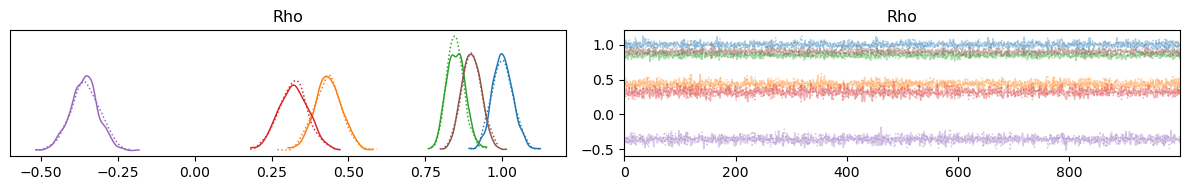

Posterior mean correlation matrix of latent Normal:
[ 1.002  0.434  0.849  0.321 -0.357  0.9  ]

True correlation matrix (used for X):
[[ 1.   0.5  0.3]
 [ 0.5  1.  -0.2]
 [ 0.3 -0.2  1. ]]


In [13]:
#Q1
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
import pymc as pm
from scipy import stats

np.random.seed(13)


# 1) Simulate correlated data in latent Normal space, then transform marginals


n = 400   # number of observations
p = 3     # dimension

# A correlation matrix to generate latent normal draws
a_cor = np.array([
    [1.00,  0.50,  0.30],
    [0.50,  1.00, -0.20],
    [0.30, -0.20,  1.00]
])

# Draw latent Normal data (N x p) with correlation a_cor
X = stats.multivariate_normal(mean=np.zeros(p), cov=a_cor).rvs(n)

# Transform each column to a non-Normal marginal
Y = np.empty_like(X)
# 1st column: Gamma( shape=5, rate=1 ) -> shape=5, scale=1/rate=1
Y[:,0] = stats.gamma(a=5, scale=1).ppf(stats.norm.cdf(X[:,0]))
# 2nd column: Exponential( scale=1 ) -> rate=1
Y[:,1] = stats.expon(scale=1).ppf(stats.norm.cdf(X[:,1]))
# 3rd column: Chi2(df=10)
Y[:,2] = stats.chi2(df=10).ppf(stats.norm.cdf(X[:,2]))

df_Y = pd.DataFrame(Y, columns=["Gamma", "Exponential", "Chi2"])


# 2) Fit each marginal separately (here, just by MLE for simplicity)


# --- Fit Gamma(a, rate=b) by MLE
gamma_shape, gamma_loc, gamma_scale = stats.gamma.fit(df_Y["Gamma"], floc=0)
gamma_rate = 1.0 / gamma_scale

# --- Fit Exponential(rate=lam) by MLE
#     Actually Exponential is a special Gamma with shape=1,
exp_rate = 1.0 / df_Y["Exponential"].mean()

# --- Fit Chi2(df=nu) by MLE
#     Method of moments: df = mean(Chi2)
chi2_df = df_Y["Chi2"].mean()

print("Fitted Marginals (MLE):")
print(f"Gamma: shape={gamma_shape:.2f}, rate={gamma_rate:.2f}")
print(f"Exponential: rate={exp_rate:.2f}")
print(f"Chi^2: df={chi2_df:.2f}")


# 3) Re‐transform data to latent Normal via Probability Integral Transform

#   Z_j = Phi^{-1}(Fhat_j( Y_j )) for each dimension j


Z = np.empty_like(Y)

# Column 0: Gamma
cdf_gamma = stats.gamma(a=gamma_shape, scale=1.0/gamma_rate)
Z[:,0] = stats.norm.ppf(cdf_gamma.cdf(Y[:,0]))

# Column 1: Exponential
cdf_exp = stats.expon(scale=1.0/exp_rate)
Z[:,1] = stats.norm.ppf(cdf_exp.cdf(Y[:,1]))

# Column 2: Chi2
cdf_chi2 = stats.chi2(df=chi2_df)
Z[:,2] = stats.norm.ppf(cdf_chi2.cdf(Y[:,2]))


# 4) Fit correlation of the latent Normal data (second pass)


with pm.Model() as copula_model:
    
    # LKJ prior for correlation (dimension = p=3)
    L, Rho, stds = pm.LKJCholeskyCov(
        'Rho', 
        n=p, 
        eta=2.0,  
        sd_dist=pm.Exponential.dist(1.0, shape=p), 
        compute_corr=True
    )

    # Observed latent data ~ MvNormal( mean=0, chol=L )
    # shape=(n, p), so each row is one observation
    z_obs = pm.MvNormal(
        'z_obs', 
        mu=np.zeros(p), 
        chol=L, 
        observed=Z
    )
    
    trace = pm.sample(draws=1000, tune=1000, chains=2, target_accept=0.9)


# Inspect posterior estimates


# Posterior for correlation matrix:
az.plot_trace(trace, var_names=["Rho"]);
plt.tight_layout()
plt.show()

Rho_post = trace.posterior["Rho"].mean(dim=["chain","draw"]).values
print("Posterior mean correlation matrix of latent Normal:")
print(np.round(Rho_post, 3))

# Compare to the "true" correlation a_cor
print("\nTrue correlation matrix (used for X):")
print(a_cor)




True nonzero coefficients:
  beta[1,0] = 2.0
  beta[3,1] = -3.0
  beta[5,2] = 1.5

Shapes:
X: (200, 60)  Y: (200, 3)

Sampling from Spike-and-Slab model...


Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [p_spike, slab, sigma]
>BinaryGibbsMetropolis: [spike]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 49 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics



Sampling from Diffuse Normal model...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta_normal, sigma_normal]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 7 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics



Sampling from Horseshoe model...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [tau, lam, raw_b, sigma_hs]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 118 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics



Spike-and-Slab: Posterior mean of Beta coefficients:
[[-0.   -0.    0.  ]
 [ 1.95  0.    0.  ]
 [-0.   -0.   -0.  ]
 [-0.   -2.95 -0.  ]
 [ 0.   -0.   -0.  ]
 [-0.    0.    1.45]
 [ 0.    0.    0.  ]
 [ 0.   -0.    0.  ]
 [ 0.    0.   -0.  ]
 [ 0.    0.    0.  ]
 [ 0.    0.    0.  ]
 [ 0.    0.   -0.  ]
 [ 0.    0.    0.  ]
 [ 0.    0.    0.  ]
 [ 0.    0.    0.  ]
 [ 0.    0.    0.  ]
 [ 0.    0.    0.  ]
 [-0.    0.    0.  ]
 [-0.    0.    0.  ]
 [-0.    0.    0.  ]
 [ 0.    0.    0.  ]
 [-0.   -0.   -0.  ]
 [ 0.    0.   -0.  ]
 [-0.    0.    0.  ]
 [ 0.    0.   -0.  ]
 [ 0.    0.    0.  ]
 [ 0.    0.    0.  ]
 [ 0.   -0.    0.  ]
 [ 0.    0.    0.  ]
 [ 0.    0.    0.  ]
 [-0.    0.   -0.  ]
 [ 0.   -0.    0.  ]
 [ 0.   -0.    0.  ]
 [ 0.    0.    0.  ]
 [ 0.    0.    0.  ]
 [-0.    0.    0.  ]
 [ 0.   -0.    0.  ]
 [ 0.   -0.   -0.  ]
 [ 0.    0.   -0.  ]
 [-0.   -0.    0.  ]
 [ 0.   -0.    0.  ]
 [ 0.    0.   -0.  ]
 [ 0.    0.   -0.  ]
 [ 0.    0.    0.  ]
 [ 0.    0.   -0.  ]
 

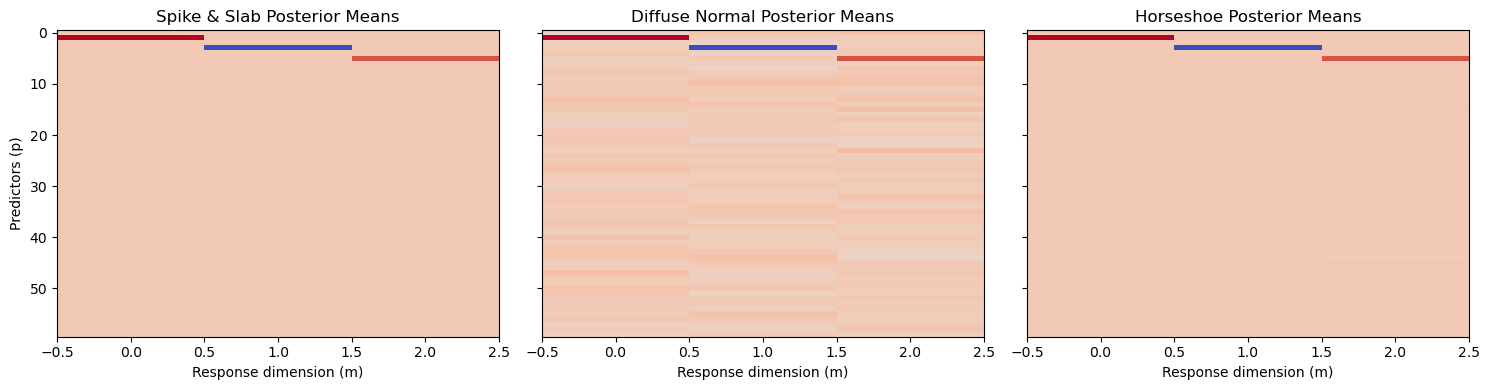

In [14]:
#Q2
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt


# 1) Generate synthetic data
np.random.seed(16)

n = 200   # Number of observations
p = 60    # Number of predictors
m = 3     # Number of response variables

# Design matrix X: shape = (n, p)
X = np.random.normal(0, 1, size=(n, p))

# True coefficients: many zero, a few nonzero
true_b = np.zeros((p, m))
true_b[1, 0] =  2.0   # predictor #1 affects response #0
true_b[3, 1] = -3.0   # predictor #3 affects response #1
true_b[5, 2] =  1.5   # predictor #5 affects response #2
# (others remain zero)

# Generate responses: Y = X @ true_b + noise
# Y shape = (n, m)
noise = np.random.normal(0, 1, size=(n, m))
Y = X @ true_b + noise

print("True nonzero coefficients:")
for (j, k) in zip(*np.where(true_b != 0)):
    print(f"  beta[{j},{k}] = {true_b[j,k]:.1f}")
print("\nShapes:")
print("X:", X.shape, " Y:", Y.shape)


# 2) Spike-and-Slab Model

#   is "in" (1) or "out" (0). The "slab" is a wide Normal. The product is
#   the effective coefficient. We allow separate sigma per response dimension.

with pm.Model() as spike_slab_model:
    
    # Prior probability of inclusion for each coeff (or can do one p per col)
    p_spike = pm.Beta("p_spike", alpha=1, beta=1)
    
    spike = pm.Bernoulli("spike", p=p_spike, shape=(p, m))
    
    # Slab: wide Normal for "active" coefficients
    slab = pm.Normal("slab", mu=0, sigma=10, shape=(p, m))
    
    # Effective coefficients
    beta_spike_slab = pm.Deterministic("beta", slab * spike)
    
    # Regression mean: (n x m)
    mu = pm.math.dot(X, beta_spike_slab)
    
    # Separate noise SD for each response dimension
    sigma = pm.HalfNormal("sigma", sigma=2.0, shape=m)
    
    # Observed data likelihood
    pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)
    
    print("\nSampling from Spike-and-Slab model...")
    trace_spike_slab = pm.sample(draws=2000, tune=1000, chains=2, target_accept=0.9)


# 3) Diffuse Normal Prior (No variable selection)
# - Here we just put a wide Normal prior on each coefficient. Compare results.

with pm.Model() as normal_model:
    
    beta_normal = pm.Normal("beta_normal", mu=0, sigma=10, shape=(p, m))
    sigma_normal = pm.HalfNormal("sigma_normal", sigma=2.0, shape=m)
    
    mu_normal = pm.math.dot(X, beta_normal)
    pm.Normal("Y_obs", mu=mu_normal, sigma=sigma_normal, observed=Y)
    
    print("\nSampling from Diffuse Normal model...")
    trace_normal = pm.sample(draws=2000, tune=1000, chains=2, target_accept=0.9)


# 4) Horseshoe Prior (an alternative strong shrinkage)

with pm.Model() as horseshoe_model:
    
    # Global shrinkage prior
    tau_0 = 1.0
    tau = pm.HalfCauchy("tau", beta=tau_0)  # shape=() => scalar global
    # Local shrinkage
    lam = pm.HalfCauchy("lam", beta=1, shape=(p,m))
    
    # Raw coefficients
    raw_b = pm.Normal("raw_b", mu=0, sigma=1, shape=(p,m))
    
    beta_hs = pm.Deterministic("beta_hs", raw_b * tau * lam)
    
    sigma_hs = pm.HalfNormal("sigma_hs", sigma=2.0, shape=m)
    mu_hs = pm.math.dot(X, beta_hs)
    pm.Normal("Y_obs", mu=mu_hs, sigma=sigma_hs, observed=Y)
    
    print("\nSampling from Horseshoe model...")
    trace_horseshoe = pm.sample(draws=2000, tune=1000, chains=2, target_accept=0.9)


# 5) Posterior Summaries and Comparisons



# --- Spike-and-Slab Results ---
print("\nSpike-and-Slab: Posterior mean of Beta coefficients:")
beta_ss_mean = trace_spike_slab.posterior["beta"].mean(["chain","draw"]).values
print(beta_ss_mean.round(2))

# --- Diffuse Normal Results ---
print("\nDiffuse Normal: Posterior mean of Beta coefficients:")
beta_nm_mean = trace_normal.posterior["beta_normal"].mean(["chain","draw"]).values
print(beta_nm_mean.round(2))

# --- Horseshoe Results ---
print("\nHorseshoe: Posterior mean of Beta coefficients:")
beta_hs_mean = trace_horseshoe.posterior["beta_hs"].mean(["chain","draw"]).values
print(beta_hs_mean.round(2))

# Quick index to show which ones are near zero vs. large
print("\nTrue Coefficients:\n", np.round(true_b,2))


# 6) Simple Visualization: Compare selected vs. actual

fig, axes = plt.subplots(1,3, figsize=(15,4), sharey=True)

axes[0].imshow(beta_ss_mean, aspect="auto", cmap="coolwarm")
axes[0].set_title("Spike & Slab Posterior Means")
axes[1].imshow(beta_nm_mean, aspect="auto", cmap="coolwarm")
axes[1].set_title("Diffuse Normal Posterior Means")
axes[2].imshow(beta_hs_mean, aspect="auto", cmap="coolwarm")
axes[2].set_title("Horseshoe Posterior Means")

for ax in axes:
    ax.set_xlabel("Response dimension (m)")
axes[0].set_ylabel("Predictors (p)")

plt.tight_layout()
plt.show()


# Observations / Discussion:
#  - The spike-and-slab model will often push truly irrelevant coefficients
#    all the way to ~0 if the posterior strongly believes they're unneeded.
#  - The horseshoe also heavily shrinks small effects, but no discrete "switch".
#  - The diffuse normal leaves many small but nonzero coefficients, no selection.
#  - Compare how each recovers the known large coefficients in 'true_b'.


Shapes: X= (200, 30)  Y= (200, 3)
True nonzero coefficients:
  beta[1,0] = 2.00
  beta[4,1] = -2.50
  beta[7,2] = 3.00

Sampling Spike-and-Slab model...


Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [p_spike, slab, sigma_spike]
>BinaryGibbsMetropolis: [spike]


Sampling 2 chains for 1_000 tune and 1_500 draw iterations (2_000 + 3_000 draws total) took 31 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics



Sampling Horseshoe model...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [tau, lam, raw_b, sigma_hs]


Sampling 2 chains for 1_000 tune and 1_500 draw iterations (2_000 + 3_000 draws total) took 85 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics



Spike-and-Slab: Posterior mean of Beta coefficients:
[[ 0.    0.    0.  ]
 [ 2.08 -0.   -0.  ]
 [-0.    0.    0.  ]
 [ 0.   -0.    0.  ]
 [-0.   -2.54  0.  ]
 [ 0.    0.   -0.  ]
 [ 0.    0.    0.  ]
 [ 0.    0.    3.01]
 [ 0.   -0.    0.  ]
 [ 0.    0.    0.  ]
 [-0.    0.    0.  ]
 [-0.   -0.    0.  ]
 [-0.   -0.    0.  ]
 [ 0.   -0.    0.  ]
 [ 0.   -0.   -0.  ]
 [ 0.    0.    0.  ]
 [ 0.    0.    0.  ]
 [-0.    0.    0.  ]
 [-0.    0.   -0.  ]
 [ 0.    0.   -0.  ]
 [ 0.    0.   -0.  ]
 [ 0.    0.   -0.  ]
 [-0.    0.   -0.  ]
 [ 0.    0.    0.  ]
 [-0.    0.   -0.  ]
 [-0.    0.   -0.  ]
 [-0.   -0.    0.  ]
 [ 0.    0.   -0.  ]
 [-0.    0.    0.  ]
 [-0.    0.    0.  ]]

Horseshoe: Posterior mean of Beta coefficients:
[[ 0.01  0.01  0.  ]
 [ 2.07  0.   -0.01]
 [-0.    0.01 -0.  ]
 [-0.    0.01 -0.  ]
 [-0.   -2.54  0.  ]
 [-0.   -0.01 -0.  ]
 [-0.01 -0.    0.01]
 [ 0.01 -0.    3.01]
 [ 0.01 -0.01 -0.  ]
 [ 0.03  0.01  0.  ]
 [-0.   -0.01 -0.  ]
 [-0.03 -0.01 -0.  ]
 [ 0.   -0.01 

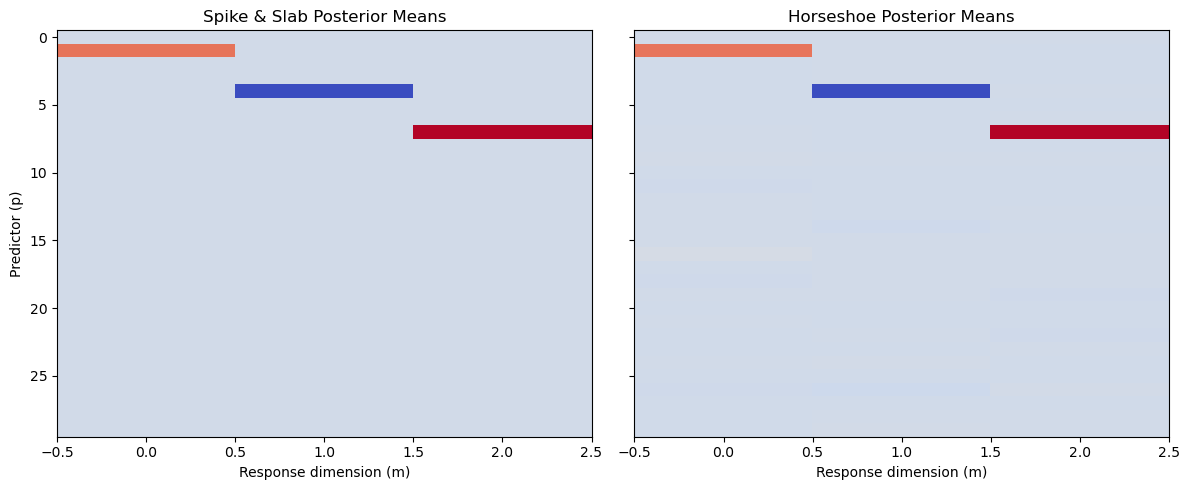

In [16]:
#Q3
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt


# 1. Generate synthetic multivariate data

np.random.seed(42)

n = 200   # number of observations
p = 30    # number of predictors
m = 3     # number of response variables

# Design matrix X: shape (n, p)
X = np.random.normal(0, 1, size=(n, p))

# True coefficients: mostly zeros, a few big signals
true_b = np.zeros((p, m))
true_b[1, 0] =  2.0
true_b[4, 1] = -2.5
true_b[7, 2] =  3.0

# Generate Y = X * B + Gaussian noise
noise = np.random.normal(0, 1.0, size=(n, m))
Y = X @ true_b + noise

print("Shapes: X=", X.shape, " Y=", Y.shape)
print("True nonzero coefficients:")
for (j,k) in zip(*np.where(true_b != 0)):
    print(f"  beta[{j},{k}] = {true_b[j,k]:.2f}")


# 2. Spike-and-Slab Model

#   We use a Bernoulli indicator for each coefficient (spike),
#   multiplied by a wide Normal (slab).

with pm.Model() as spike_slab_model:
    
    # Probability of inclusion
    p_spike = pm.Beta("p_spike", alpha=1, beta=1)
    
    # Bernoulli indicators, shape=(p, m)
    spike = pm.Bernoulli("spike", p=p_spike, shape=(p, m))
    
    # Slab: wide Normal
    slab = pm.Normal("slab", mu=0, sigma=10, shape=(p, m))
    
    # Effective coefficients
    beta_spike = pm.Deterministic("beta_spike", slab * spike)
    
    # Separate noise scale per response
    sigma_spike = pm.HalfNormal("sigma_spike", sigma=2.0, shape=m)
    
    # Likelihood
    mu_spike = pm.math.dot(X, beta_spike)
    pm.Normal("Y_obs_spike", mu=mu_spike, sigma=sigma_spike, observed=Y)
    
    print("\nSampling Spike-and-Slab model...")
    trace_spike_slab = pm.sample(
        draws=1500, tune=1000, chains=2,
        target_accept=0.9, random_seed=42
    )


# 3. Horseshoe Model

#   Beta_{j,k} = raw_{j,k} * tau * lam_{j,k}


with pm.Model() as horseshoe_model:
    
    tau_0 = 0.5
    tau = pm.HalfCauchy("tau", beta=tau_0)  # global scale (scalar)
    
    lam = pm.HalfCauchy("lam", beta=1.0, shape=(p, m))  # local scales
    
    raw_b = pm.Normal("raw_b", mu=0, sigma=1, shape=(p, m))
    beta_hs = pm.Deterministic("beta_hs", raw_b * tau * lam)
    
    sigma_hs = pm.HalfNormal("sigma_hs", sigma=2.0, shape=m)
    
    mu_hs = pm.math.dot(X, beta_hs)
    pm.Normal("Y_obs_hs", mu=mu_hs, sigma=sigma_hs, observed=Y)
    
    print("\nSampling Horseshoe model...")
    trace_horseshoe = pm.sample(
        draws=1500, tune=1000, chains=2,
        target_accept=0.9, random_seed=42
    )


# 4. Extract Posterior Means and Compare

beta_ss_mean = trace_spike_slab.posterior["beta_spike"].mean(dim=["chain","draw"]).values
beta_hs_mean = trace_horseshoe.posterior["beta_hs"].mean(dim=["chain","draw"]).values

print("\nSpike-and-Slab: Posterior mean of Beta coefficients:")
print(beta_ss_mean.round(2))
print("\nHorseshoe: Posterior mean of Beta coefficients:")
print(beta_hs_mean.round(2))

print("\nTrue coefficients:")
print(true_b.round(2))


# 5. Visualization

fig, axes = plt.subplots(1,2, figsize=(12,5), sharey=True)

axes[0].imshow(beta_ss_mean, aspect="auto", cmap="coolwarm")
axes[0].set_title("Spike & Slab Posterior Means")
axes[1].imshow(beta_hs_mean, aspect="auto", cmap="coolwarm")
axes[1].set_title("Horseshoe Posterior Means")

for ax in axes:
    ax.set_xlabel("Response dimension (m)")
axes[0].set_ylabel("Predictor (p)")

plt.tight_layout()
plt.show()


# Observations:
#  - Both methods heavily shrink many coefficients to near zero.
#  - Spike-and-Slab can 'switch off' many completely (exact zero),
#    while Horseshoe typically just strongly shrinks them but not exactly zero.
#  - Compare the few truly large signals (indices [1,0], [4,1], [7,2]) and see
#    how well they are recovered in each approach.
